In [1]:
using Pkg
#Pkg.add("Distributions")
using Random, Distributions
using PyPlot
using Optim

In [2]:
#coordination game

#player, action 1, action 2
payoffs = [ [3 -1 ; 0 0], [1 -3 ; 0 0] ]

#player, action (not yours)
priors = [[3 1 ; 3 1],[1 3 ; 1 3]]
mix = [.5 ; .5]

function simulate_game(payoffs,mix; 
        beliefs=[[3 1 ; 3 1],[1 3 ; 1 3]],T=5,update=true)
    
    #infer # of players and actions
    players = 2
    actions = 2
    trial = zeros(T,players)
    
    #choose a prior
    beliefs_distr = Categorical(mix)
    beliefs = beliefs[rand(beliefs_distr)]
    beliefs = beliefs[:,:]
    
    for t =1:T
        choices = []
        for k=1:players
            expected_payoffs = []
            for i=1:actions
                belief_t = beliefs[k,:]/sum(beliefs[k,:])
                payoff = sum( belief_t .* payoffs[k][i,:]) + rand(Gumbel())
                append!(expected_payoffs,payoff)
            end
            append!(choices,argmax(expected_payoffs))
        end
        for k=1:players
            if choices[k]==1
                trial[t,k] = 1
            end
            
            if update
                not_k = mod(k,2)+1
                beliefs[k,choices[not_k]] = beliefs[k,choices[not_k]] +1
            end
        end
    end
    
    return trial
end


simulate_game(payoffs,mix)

5×2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 1.0  0.0
 0.0  0.0

In [3]:
function gen_support(t) 
    result = zeros(2^(2*t),t,2)
    for i=1:2^(2*t)
        i_copy = i
        binary = zeros(2*t)
        for digit=1:2*t
            if mod(i_copy,2) > 0
                binary[digit] = 1
                i_copy = i_copy - 1
            end
            i_copy = i_copy/2
        end
        result[i,:,1] = binary[1:t]
        result[i,:,2] = binary[t+1:end]
    end
    return result
end


gen_support (generic function with 1 method)

[1.0 0.0; 0.0 0.0] 1

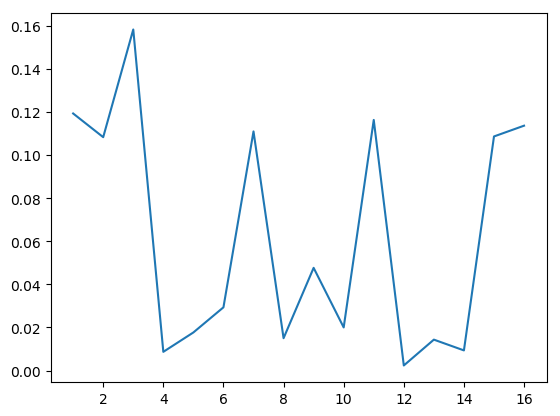


[0.0 0.0; 1.0 0.0] 2
[1.0 0.0; 1.0 0.0] 3
[0.0 1.0; 0.0 0.0] 4
[1.0 1.0; 0.0 0.0] 5
[0.0 1.0; 1.0 0.0] 6
[1.0 1.0; 1.0 0.0] 7
[0.0 0.0; 0.0 1.0] 8
[1.0 0.0; 0.0 1.0] 9
[0.0 0.0; 1.0 1.0] 10
[1.0 0.0; 1.0 1.0] 11
[0.0 1.0; 0.0 1.0] 12
[1.0 1.0; 0.0 1.0] 13
[0.0 1.0; 1.0 1.0] 14
[1.0 1.0; 1.0 1.0] 15
[0.0 0.0; 0.0 0.0] 16


In [4]:
#set up a non-linear equation for each distr
function empirical_pr_sim(payoffs,mix; 
        beliefs=[[3 1 ; 3 1],[1 3 ; 1 3]],T=5,N=3000)
    #enumerate outcomes
    outcomes = gen_support(T)
    outcomes_pr = zeros(size(outcomes)[1])
    Random.seed!(123)
    
    for i=1:N
        draw = simulate_game(payoffs,mix; beliefs=beliefs,T=T)
        for j=1:2^(2*T)
            if draw == outcomes[j,:,:]
                outcomes_pr[j] = outcomes_pr[j]+1
            end
        end
    end
    return outcomes_pr/N
end

#player, action 1, action 2
payoffs = [ [3 -1 ; 0 0], [1 -3 ; 0 0] ]

#player, action (not yours)
mix = [.5 ; .5]

T=2
sim_pr = empirical_pr_sim(payoffs,mix,T=T;)
plot(collect(1:2^(2*T)), sim_pr)

support = gen_support(T)
for i=1:2^(2*T)
    println(support[i,:,:]," $(i)")
end

In [5]:
function gmm_obj_payoffs(params, obs_pr ; T=5)   
    
    #initialize array of 0s
    moments = zeros( 2^(2*T) +1)
    
    #deal with probability parameters
    mix = [max(params[5],0) ; max(params[6],0)]
    denom = sum(mix)
    mix = mix/denom
    moments[1] = (denom -1)
    
    
    #simulate the rest of the equations
    payoffs = [ [ params[1] params[2]; 0 0 ], [params[3] params[4] ; 0 0] ]
    #subtract simulated from reality
    moments[2:end] = obs_pr - empirical_pr_sim(payoffs, mix ; T=T)
    result = sum(moments .* moments)
    println(result," ",params)
    return result
end

#player, action 1, action 2
payoffs = [ [3 -1 ; 0 0], [1 -3 ; 0 0] ]
#player, action (not yours)
mix = [0.5 ; 0.5]
T=2
sim_pr = empirical_pr_sim(payoffs,mix;T=T)
gmm_obj_payoffs( [3 -1 1 -3 .5 .5], sim_pr ;T=T)

0.001146666666666666 [3.0 -1.0 1.0 -3.0 0.5 0.5]


0.001146666666666666

In [6]:
function estimate_payoffs(obs_pr; T=5)
    obj(x) = gmm_obj_payoffs(x, obs_pr ;T=T)
        
    res = optimize(obj,[1. 1. 1. 1. .5 .5], NelderMead(),
        Optim.Options(iterations = 1000,x_tol=1e-20,f_tol=1e-20))
    return res.minimizer
end

#player, action 1, action 2
payoffs = [ [3. -1. ; 0. 0.], [1. -3. ; 0. 0.] ]
#player, action (not yours)
mix = [0.5 ; 0.5]
T=3
sim_pr = empirical_pr_sim(payoffs,mix;T=T)

println(estimate_payoffs(sim_pr; T=T))

0.038845111111111115 [1.0 1.0 1.0 1.0 0.5 0.5]
0.041164222222222234 [1.0 1.0 1.0 1.0 0.5 0.5]
0.04586977777777779 [1.525 1.0 1.0 1.0 0.5 0.5]
0.04427822222222222 [1.0 1.525 1.0 1.0 0.5 0.5]
0.0532728888888889 [1.0 1.0 1.525 1.0 0.5 0.5]
0.05236666666666667 [1.0 1.0 1.0 1.525 0.5 0.5]
0.11622877777777772 [1.0 1.0 1.0 1.0 0.775 0.5]
0.1179914444444444 [1.0 1.0 1.0 1.0 0.5 0.775]
0.08558755555555561 [1.175 1.175 1.175 1.175 0.591667 0.225]
0.17212112345679023 [1.23333 1.23333 1.23333 1.23333 0.255556 0.408333]
0.07263494787379966 [1.03889 1.03889 1.03889 1.03889 0.688426 0.484722]
0.10142502713001067 [1.01296 1.01296 1.01296 1.01296 0.471142 0.769907]
0.06588540873257807 [1.14799 1.14799 1.14799 1.14799 0.571579 0.315818]
0.10018420235218967 [1.18544 1.18544 1.18544 1.18544 0.335434 0.453884]
0.055082593753913625 [1.06331 1.06331 1.06331 1.06331 0.629594 0.479582]
0.06667817918967768 [1.04811 1.04811 1.04811 1.04811 0.471619 0.677376]
0.055937668315585394 [1.13135 1.13135 1.13135 1.13135 

0.0035682474009963642 [1.48242 -0.639065 0.958169 -2.93196 0.553861 0.434128]
0.003970514102251115 [1.56497 -0.775679 1.10358 -3.18478 0.56427 0.421321]
0.005455256093784599 [1.70401 0.155186 0.852786 -2.32835 0.54903 0.433639]
0.004218724587384711 [1.71249 -0.0399315 0.938398 -3.07431 0.560025 0.43796]
0.001920591635709387 [2.00577 -0.360455 0.970662 -2.71519 0.538586 0.460292]
0.002245253908797101 [2.16435 -0.423951 1.04286 -2.78126 0.538337 0.462268]
0.002057664309043081 [1.77007 -0.335091 1.40907 -3.35894 0.505662 0.471846]
0.003969400007436134 [1.55703 -0.747452 1.05869 -3.30921 0.506578 0.493681]
0.0026574387087476385 [1.70362 -0.402755 1.65509 -3.65325 0.56995 0.449178]
0.0015350984904293117 [2.15542 -0.768325 1.32886 -3.83087 0.56042 0.41999]
0.001969861459722011 [2.30548 -0.884169 1.38348 -4.04989 0.567523 0.407371]
0.004379233975265702 [1.84562 -1.04445 1.52178 -3.5255 0.518327 0.471745]
0.0026902224974277274 [1.73468 -0.207351 1.03563 -3.14951 0.553076 0.443591]
0.0030690604

0.00040735266106053627 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000860338798782456 [2.55014 -0.987077 1.1701 -3.78319 0.604576 0.392279]
0.0006935414808656544 [2.69714 -0.991734 1.12726 -3.764 0.613331 0.387125]
0.0006362593650795927 [2.60134 -0.880199 1.18878 -3.67236 0.597871 0.4033]
0.0007126761291486628 [2.53101 -0.923179 1.19528 -3.72493 0.597746 0.400426]
0.0006468945848108573 [2.66945 -0.980308 1.1386 -3.75749 0.610734 0.389342]
0.0007543176836661964 [2.5587 -0.934605 1.18394 -3.73145 0.600343 0.398209]
0.0008422540377352568 [2.651 -0.972691 1.14616 -3.75315 0.609002 0.39082]
0.0007537474456201838 [2.60933 -0.914429 1.11566 -3.65988 0.60388 0.394019]
0.0005253090365951983 [2.63365 -1.02498 1.1996 -3.8454 0.61173 0.386014]
0.0005984445822542189 [2.62639 -0.987806 1.12029 -3.70733 0.607753 0.392235]
0.0006008872216878631 [2.59456 -0.971162 1.17658 -3.81728 0.607108 0.393558]
0.000992518673935765 [2.60645 -0.888905 1.19421 -3.69243 0.597221 0.403051]
0.0005732987673

0.0005885128602836012 [2.63568 -0.942841 1.21757 -3.79548 0.596293 0.40017]
0.0007457329946938213 [2.63866 -0.954842 1.21084 -3.8021 0.597523 0.398862]
0.0006960490188580411 [2.6348 -0.954292 1.22771 -3.82088 0.596536 0.399746]
0.00045285778482382803 [2.64095 -0.946963 1.22298 -3.8012 0.59596 0.400362]
0.0006380484822502406 [2.63885 -0.940445 1.21964 -3.79594 0.594441 0.401993]
0.0010036396886585477 [2.63247 -0.933421 1.22768 -3.79544 0.593897 0.40244]
0.0005451245277749845 [2.63763 -0.951272 1.21364 -3.80099 0.596919 0.399458]
0.0008876512052438595 [2.64222 -0.941606 1.23468 -3.81616 0.594318 0.401351]
0.0006941204316428907 [2.63294 -0.946776 1.21102 -3.79126 0.5966 0.400082]
0.00047514599174500925 [2.63788 -0.932619 1.20769 -3.77169 0.59486 0.401545]
0.0008662647368854333 [2.64139 -0.935416 1.22328 -3.79478 0.594215 0.401697]
0.0005789881345820122 [2.63435 -0.944883 1.21306 -3.79185 0.596203 0.400351]
0.0008773292214676637 [2.63398 -0.943227 1.21247 -3.78874 0.596962 0.399238]
0.0006

0.0005401702492840905 [2.63209 -0.932424 1.22069 -3.79251 0.593961 0.401855]
0.0006298844864050685 [2.63259 -0.932116 1.21982 -3.79073 0.593985 0.401839]
0.0008218486445212113 [2.63338 -0.932389 1.22179 -3.79242 0.593867 0.401935]
0.000746215526779501 [2.63199 -0.933023 1.21956 -3.79168 0.594144 0.40172]
0.0005775213932740764 [2.63311 -0.932516 1.22135 -3.79227 0.593922 0.401892]
0.0008152212714998431 [2.63287 -0.934185 1.22105 -3.79414 0.594238 0.401585]
0.0006299623550088455 [2.63252 -0.932068 1.22037 -3.79105 0.593916 0.401925]
0.0007383491748080538 [2.63184 -0.929693 1.22118 -3.79013 0.593625 0.402117]
0.0008616609005290062 [2.633 -0.934215 1.22034 -3.79301 0.59421 0.401667]
0.0006213301113857944 [2.63208 -0.932427 1.2208 -3.79256 0.593963 0.401847]
0.000702233862509256 [2.63292 -0.932503 1.22135 -3.79236 0.593931 0.401878]
0.0011618849813376268 [2.63276 -0.932803 1.22061 -3.79195 0.594079 0.401772]
0.0009992770790601133 [2.6325 -0.932169 1.22007 -3.79108 0.593983 0.401834]
0.00064

0.0005566835010126404 [2.632 -0.932421 1.22144 -3.79287 0.593955 0.401827]
0.0008490412107565273 [2.63215 -0.932585 1.22137 -3.79289 0.593989 0.401803]
0.0006835188914162227 [2.63213 -0.932452 1.22137 -3.79274 0.593971 0.401817]
0.0006986651342717611 [2.63197 -0.932393 1.22124 -3.79266 0.593964 0.40182]
0.0004764367989270867 [2.63205 -0.93244 1.22129 -3.79273 0.593962 0.401822]
0.000822388062763087 [2.63215 -0.932565 1.22137 -3.79287 0.593982 0.401808]
0.0008373226535052282 [2.632 -0.932421 1.22126 -3.7927 0.593967 0.401818]
0.0011575524041584164 [2.63205 -0.932439 1.2213 -3.79275 0.593964 0.40182]
0.00086774688301112 [2.63202 -0.932442 1.22125 -3.79274 0.59397 0.401817]
0.0008271283610084937 [2.632 -0.932424 1.22143 -3.79286 0.593958 0.401823]
0.0009307882972066966 [2.63212 -0.932637 1.22117 -3.79274 0.594001 0.401795]
0.0008170837728233215 [2.63211 -0.93245 1.22137 -3.79276 0.593971 0.401816]
0.0008560019434426456 [2.63197 -0.9324 1.22126 -3.79269 0.593965 0.401818]
0.000896851899750

0.0008051332264967586 [2.63201 -0.932434 1.22137 -3.79282 0.593974 0.401807]
0.0008102282167543167 [2.63202 -0.932451 1.22135 -3.79281 0.593977 0.401806]
0.0007157977551676243 [2.632 -0.932438 1.22137 -3.79284 0.593974 0.401807]
0.0006733551269283586 [2.63201 -0.932436 1.22138 -3.79284 0.593975 0.401806]
0.0007289038840278042 [2.632 -0.932454 1.22134 -3.79282 0.593979 0.401803]
0.0006569162297041154 [2.632 -0.932425 1.22137 -3.79283 0.593974 0.401807]
0.0009627025280328934 [2.63198 -0.932424 1.22138 -3.79285 0.593973 0.401807]
0.0009131220817086994 [2.63201 -0.932446 1.22135 -3.79282 0.593977 0.401806]
0.0008560260051753107 [2.632 -0.932427 1.22137 -3.79283 0.593974 0.401807]
0.0006409102714940809 [2.63201 -0.932436 1.22137 -3.79284 0.593975 0.401806]
0.0008782420913341381 [2.632 -0.932438 1.22137 -3.79284 0.593974 0.401807]
0.000872904606089226 [2.632 -0.932451 1.22134 -3.79282 0.593978 0.401804]
0.0008317994285385246 [2.63201 -0.932434 1.22137 -3.79282 0.593974 0.401807]
0.0008111193

0.000912242124920822 [2.63201 -0.932436 1.22136 -3.79283 0.593974 0.401807]
0.0009897960611588955 [2.63201 -0.932438 1.22136 -3.79283 0.593974 0.401808]
0.000982241253698814 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009842427809143375 [2.632 -0.932435 1.22137 -3.79283 0.593974 0.401808]
0.000666240178444207 [2.63201 -0.932438 1.22136 -3.79283 0.593974 0.401807]
0.0009426853154264933 [2.63201 -0.932438 1.22136 -3.79283 0.593974 0.401807]
0.0005733517937340974 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010737959653340436 [2.63201 -0.932438 1.22136 -3.79283 0.593974 0.401808]
0.001322464251313834 [2.63201 -0.932436 1.22136 -3.79283 0.593974 0.401807]
0.0005931295685477822 [2.63201 -0.932438 1.22136 -3.79283 0.593974 0.401808]
0.0007869056243016987 [2.63201 -0.932439 1.22136 -3.79283 0.593974 0.401807]
0.0007704619416197419 [2.63201 -0.932439 1.22136 -3.79283 0.593974 0.401808]
0.0006931286071334346 [2.63201 -0.932438 1.22136 -3.79283 0.593974 0.401808]
0.000

0.0008446854048225524 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006055742971995565 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0004644632871625057 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000820018506297684 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007464633373462666 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009031299195812145 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007817965234761136 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006893520575751142 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007973521971251293 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006097963268748697 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000948907803613102 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006300185281198369 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006424629853676795 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0

0.0005924630792348939 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007444631071013398 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008729074973468189 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008895742185590171 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005633519718684575 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008306852916789619 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.00120535196853051 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008255742043179505 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008591297695303242 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006824631122433928 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000954240878944641 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006069075420237658 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008097964095167182 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.

0.0007591297489232474 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009373519691223338 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000693129745598796 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009626853048562964 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000967574189749806 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000981129746336035 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007560186386465142 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0011080186376210392 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005902408578464996 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008271297502395004 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006935741910014836 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000727351971065535 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006442408561496392 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0

0.0009111297488991704 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0004351297487624336 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007529075262792617 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0011262408600410084 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008953519704647762 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007142408591655195 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008889075264260869 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009395741930251272 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006320186375812373 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008569075261823551 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007313519707752358 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.001188907525880106 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010251297484748898 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]


0.0007782408594532919 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008904630816201678 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006871297482939814 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000497574192776198 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008377964150119994 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009655741927183821 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005517964149665214 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010106853038423457 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008782408594532497 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006655741928221678 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005291297483213842 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006115741927546523 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007540186372558553 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]


0.0007760186372612978 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008015741928178032 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009062408594836021 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006835741928182899 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007717964150352221 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008820186372720743 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0004646853039278717 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.001182685303932334 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010117964150398726 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008817964150396879 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010755741928187394 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009557964150365536 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007151297483738906 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]


0.0009380186372652954 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0011346853039326235 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007166853039318609 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005433519705984968 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010100186372659491 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008553519705980855 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007693519705976959 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008217964150424831 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007200186372652316 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0013877964150432328 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005380186372648299 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009793519705992835 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007269075261535166 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]

0.0008000186372654473 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006655741928209061 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007240186372653743 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007264630817098261 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008720186372653967 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006764630817098467 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007891297483764458 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006237964150431315 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008115741928209201 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008264630817098411 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.00047312974837647773 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007046853039320315 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008864630817098513 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808

0.001105129748376539 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000676463081709875 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008306853039321061 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000722907526154326 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007106853039320969 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008004630817098841 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000917351970598759 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007851297483765573 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005080186372654322 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009826853039320977 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007186853039321052 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008366853039320875 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010597964150432196 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0

0.0008433519705987676 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0011306853039320958 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005884630817098783 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007724630817098745 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008817964150432118 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.00077779641504321 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006697964150432119 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0013231297483765492 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006724630817098746 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009106853039320988 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008304630817098785 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007115741928209878 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006733519705987676 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0

0.0007589075261543231 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000529796415043212 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006842408594876563 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007186853039321007 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009213519705987675 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000603796415043212 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007404630817098784 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008246853039321008 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006711297483765454 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008942408594876563 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000692685303932101 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008633519705987674 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006580186372654341 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.

0.0007324630817098782 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.001178018637265434 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.00047624085948765635 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009302408594876566 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0011040186372654344 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009326853039321008 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005644630817098787 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010157964150432118 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000678907526154323 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009037964150432116 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006046853039321006 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006575741928209895 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000624907526154323 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0

0.0009531297483765451 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000666907526154323 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005526853039321009 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007073519705987671 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.001162907526154323 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006633519705987675 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007464630817098788 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009269075261543226 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009013519705987675 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007306853039321006 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008826853039321011 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006989075261543227 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010604630817098787 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0

0.0007426853039321009 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007095741928209895 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007615741928209897 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007417964150432119 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009033519705987674 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009075741928209899 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008253519705987676 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006415741928209898 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010493519705987674 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005489075261543231 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.001328018637265434 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006495741928209898 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006406853039321007 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]


0.0009055741928209899 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008842408594876561 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009457964150432119 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009829075261543227 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007113519705987675 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006624630817098786 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005049075261543229 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007675741928209897 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000696018637265434 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0004677964150432118 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009100186372654343 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005600186372654343 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007575741928209895 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]


0.0008184630817098786 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008000186372654339 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0004953519705987675 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005737964150432118 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009255741928209894 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005464630817098788 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008235741928209896 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008000186372654343 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007997964150432121 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000625129748376545 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007602408594876563 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008589075261543227 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010933519705987674 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]


0.0007340186372654339 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007537964150432116 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008262408594876566 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009280186372654344 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009366853039321006 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006435741928209896 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0010249075261543228 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008864630817098786 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008649075261543228 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000982907526154323 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007717964150432121 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006602408594876565 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005035741928209898 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]


0.0008015741928209899 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006342408594876565 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008691297483765454 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0009955741928209898 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006693519705987677 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008304630817098783 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.000984685303932101 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0006533519705987674 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0005315741928209896 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0008609075261543231 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007562408594876564 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007273519705987676 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]
0.0007769075261543231 [2.63201 -0.932437 1.22136 -3.79283 0.593974 0.401808]


In [7]:
#player, action 1, action 2
payoffs = [ [3. -1. ; 0. 0.], [1. -3. ; 0. 0.] ]
#player, action (not yours)
mix = [0.2 ; 0.8]
T=4
sim_pr = empirical_pr_sim(payoffs,mix;T=T)

println(estimate_payoffs(sim_pr; T=T))

0.02659911111111111 [1.0 1.0 1.0 1.0 0.5 0.5]
0.02698777777777778 [1.0 1.0 1.0 1.0 0.5 0.5]
0.031572222222222224 [1.525 1.0 1.0 1.0 0.5 0.5]
0.03125688888888889 [1.0 1.525 1.0 1.0 0.5 0.5]
0.03568977777777778 [1.0 1.0 1.525 1.0 0.5 0.5]
0.031844 [1.0 1.0 1.0 1.525 0.5 0.5]
0.10213211111111106 [1.0 1.0 1.0 1.0 0.775 0.5]
0.10378988888888888 [1.0 1.0 1.0 1.0 0.5 0.775]
0.07033555555555561 [1.175 1.175 1.175 1.175 0.591667 0.225]
0.15274756790123462 [1.23333 1.23333 1.23333 1.23333 0.255556 0.408333]
0.05748717009602191 [1.03889 1.03889 1.03889 1.03889 0.688426 0.484722]
0.08609213824112179 [1.01296 1.01296 1.01296 1.01296 0.471142 0.769907]
0.04862007539924474 [1.14799 1.14799 1.14799 1.14799 0.571579 0.315818]
0.08089198012996743 [1.18544 1.18544 1.18544 1.18544 0.335434 0.453884]
0.04167370486502475 [1.06331 1.06331 1.06331 1.06331 0.629594 0.479582]
0.052123956967455476 [1.04811 1.04811 1.04811 1.04811 0.471619 0.677376]
0.036773890537807614 [1.13135 1.13135 1.13135 1.13135 0.554919 0

0.005319356495801452 [-1.63548 1.27976 -3.43785 1.62684 0.641776 0.345125]
0.004639743960183 [-1.7952 1.44273 -3.96566 1.7291 0.684617 0.322514]
0.005827807640766945 [-2.20201 1.56123 -3.88492 1.38613 0.715308 0.297638]
0.00546648195090493 [-1.7299 1.32667 -3.51236 1.58672 0.654031 0.337211]
0.004936318952751657 [-1.67705 1.11066 -3.40756 1.42501 0.65519 0.340882]
0.004272009052905882 [-1.83009 1.40434 -3.95227 1.68109 0.684832 0.319666]
0.004517716354250219 [-2.23152 1.63564 -3.71425 1.39666 0.64625 0.352527]
0.005141076013904103 [-2.10269 1.47563 -3.74454 1.67774 0.719428 0.281805]
0.004748929000908061 [-1.75236 1.47622 -3.48829 1.35192 0.687008 0.312028]
0.004771448160812411 [-1.69698 1.26853 -3.51242 1.59587 0.649131 0.338509]
0.004070672821237359 [-1.62815 1.22696 -3.5755 1.28612 0.616678 0.37454]
0.0042958851014610515 [-1.54906 1.18551 -3.54732 1.22085 0.599553 0.389996]
0.0043654398592045274 [-2.03749 1.63069 -3.96845 1.49254 0.668079 0.326683]
0.00485478174175003 [-2.13106 1.59

0.003966816711078273 [-1.49815 0.897598 -3.7879 1.1407 0.592859 0.393694]
0.003751528372660871 [-1.51213 0.896193 -3.73502 1.10282 0.600086 0.385142]
0.004078239103893237 [-1.52497 0.854074 -3.7594 1.08652 0.59225 0.390844]
0.0037742071644923697 [-1.50262 0.890344 -3.78315 1.13167 0.592758 0.393219]
0.003838337184264172 [-1.5641 0.895761 -3.73846 1.12856 0.591112 0.3951]
0.0040089696557083455 [-1.5484 0.890554 -3.74912 1.12495 0.591541 0.394314]
0.004277245060741808 [-1.50177 0.86373 -3.77476 1.10515 0.584906 0.399865]
0.0037167320585773183 [-1.52575 0.906057 -3.7462 1.10717 0.598509 0.386641]
0.0040358948029003815 [-1.56132 0.887564 -3.81435 1.13956 0.59861 0.387386]
0.004036159564301875 [-1.51783 0.901183 -3.78631 1.1312 0.592402 0.393372]
0.0038712719418289355 [-1.47838 0.842168 -3.73058 1.10558 0.587572 0.396444]
0.0044216412078603015 [-1.49058 0.879662 -3.80236 1.11057 0.593177 0.391009]
0.003942403005623957 [-1.56906 0.905697 -3.74906 1.12861 0.591031 0.394939]
0.0041461006327173

0.004325705287912804 [-1.57825 0.949076 -3.79458 1.12229 0.589767 0.394823]
0.004047249888777061 [-1.59462 0.953633 -3.79944 1.12905 0.591704 0.393273]
0.0038896912243268854 [-1.58519 0.949112 -3.79942 1.12545 0.589978 0.394859]
0.004495768304108895 [-1.59556 0.959453 -3.79936 1.1261 0.591413 0.39337]
0.003979336629896076 [-1.59047 0.954695 -3.80174 1.12938 0.591348 0.393567]
0.0042369453317813695 [-1.58618 0.949589 -3.79322 1.12562 0.590191 0.394568]
0.003989475258039604 [-1.58297 0.946202 -3.79375 1.12518 0.591717 0.393098]
0.004032176278290659 [-1.59723 0.954683 -3.80069 1.13015 0.591847 0.393158]
0.003822262822888091 [-1.58308 0.943766 -3.79761 1.12879 0.590489 0.394425]
0.003937101013225351 [-1.59143 0.951689 -3.80521 1.13032 0.59181 0.393179]
0.0040482629969484235 [-1.57845 0.945597 -3.79924 1.12585 0.590141 0.394597]
0.003924847476820017 [-1.5941 0.953169 -3.80045 1.12943 0.591563 0.393398]
0.004055472497155588 [-1.59641 0.956399 -3.80842 1.13224 0.590221 0.394756]
0.00405665634

0.003820526983016114 [-1.59239 0.954282 -3.80062 1.12834 0.590906 0.39386]
0.004109819249846831 [-1.59265 0.954283 -3.80134 1.12885 0.590771 0.393989]
0.004028290394159227 [-1.59406 0.955883 -3.80214 1.12865 0.590848 0.393925]
0.004272624559739499 [-1.59293 0.954603 -3.8015 1.12881 0.590787 0.393976]
0.003846790516155423 [-1.59387 0.95567 -3.80204 1.12867 0.590838 0.393934]
0.0036230642119687542 [-1.5947 0.955717 -3.80178 1.12915 0.590913 0.393872]
0.0040494093365472566 [-1.59431 0.955758 -3.80156 1.12864 0.590875 0.393876]
0.003555357150327383 [-1.59362 0.955247 -3.80196 1.12891 0.590829 0.393953]
0.0037305875808632013 [-1.59297 0.954267 -3.801 1.12862 0.590836 0.393943]
0.0036215372078264316 [-1.59312 0.954811 -3.80131 1.12872 0.590697 0.394079]
0.004044396803263186 [-1.59302 0.954229 -3.80087 1.12887 0.590764 0.394014]
0.0037992063744165367 [-1.59373 0.95543 -3.80184 1.12871 0.590826 0.393947]
0.0038210351555490398 [-1.59495 0.956 -3.8027 1.12933 0.590669 0.394116]
0.004274426438793

0.004110086016915321 [-1.59363 0.955257 -3.80205 1.12881 0.590603 0.394155]
0.004001242648937927 [-1.5938 0.955312 -3.80208 1.12886 0.590606 0.394151]
0.003977183814856494 [-1.59386 0.955401 -3.80216 1.12887 0.590621 0.394138]
0.004347686276379054 [-1.59365 0.955245 -3.80204 1.12882 0.590613 0.394144]
0.004426518916449272 [-1.59389 0.955421 -3.80214 1.12887 0.590607 0.394151]
0.004695677193690214 [-1.59374 0.955338 -3.80206 1.12882 0.59061 0.394147]
0.003935432266217524 [-1.59387 0.95542 -3.80216 1.12887 0.590602 0.394156]
0.004213845832220722 [-1.59387 0.955397 -3.80215 1.12887 0.590621 0.394138]
0.0037394504151695243 [-1.59382 0.955322 -3.80208 1.12886 0.590609 0.394149]
0.004466523593058154 [-1.59367 0.955276 -3.80205 1.12882 0.590607 0.394152]
0.0043467268206025915 [-1.59393 0.955443 -3.80215 1.12889 0.590609 0.39415]
0.004060701091488233 [-1.59394 0.955406 -3.80216 1.12892 0.590614 0.394146]
0.004172728668581731 [-1.59409 0.955511 -3.8022 1.12894 0.59062 0.394139]
0.00424274827935

0.004441149355244168 [-1.59388 0.955374 -3.80207 1.12889 0.590625 0.394135]
0.0044738150281659885 [-1.59391 0.955397 -3.80208 1.1289 0.590625 0.394135]
0.004045600560074657 [-1.59387 0.955371 -3.80208 1.12888 0.590623 0.394136]
0.004008268486461074 [-1.59389 0.955394 -3.8021 1.12889 0.590623 0.394137]
0.004144480260100312 [-1.5939 0.955389 -3.80209 1.1289 0.590627 0.394133]
0.004346037860630136 [-1.5939 0.955388 -3.80209 1.12889 0.590626 0.394134]
0.003926492216632065 [-1.59389 0.955387 -3.80208 1.12889 0.590624 0.394136]
0.003999806823495131 [-1.59391 0.955393 -3.80208 1.1289 0.590627 0.394133]
0.0037384904660812805 [-1.59389 0.95539 -3.80209 1.12889 0.590623 0.394137]
0.004084711638537352 [-1.59387 0.955372 -3.80208 1.12889 0.590624 0.394136]
0.003952930830748191 [-1.59389 0.955386 -3.80209 1.12889 0.590624 0.394136]
0.004297603095022486 [-1.59388 0.955381 -3.80208 1.12889 0.590622 0.394138]
0.003917370647805904 [-1.5939 0.955387 -3.80209 1.12889 0.590627 0.394133]
0.0037509262184632

0.0036607072615327807 [-1.59389 0.95538 -3.80208 1.12889 0.590626 0.394134]
0.004299153667081027 [-1.59388 0.955376 -3.80207 1.12889 0.590625 0.394134]
0.0038724878286943566 [-1.59388 0.955378 -3.80208 1.12889 0.590625 0.394135]
0.004168043835003173 [-1.59389 0.955378 -3.80208 1.12889 0.590625 0.394135]
0.004412710266664943 [-1.59388 0.955378 -3.80208 1.12889 0.590625 0.394135]
0.0039631524082683256 [-1.59389 0.955379 -3.80208 1.12889 0.590626 0.394134]
0.0038367096701664018 [-1.59388 0.955376 -3.80208 1.12889 0.590625 0.394135]
0.004038043621646066 [-1.59388 0.955378 -3.80208 1.12889 0.590625 0.394135]
0.004030043745581449 [-1.59388 0.955378 -3.80208 1.12889 0.590625 0.394135]
0.003919155093175904 [-1.59388 0.955376 -3.80208 1.12889 0.590625 0.394135]
0.003973820600028012 [-1.59388 0.955376 -3.80208 1.12889 0.590625 0.394135]
0.004291820709190059 [-1.59388 0.955376 -3.80207 1.12889 0.590625 0.394134]
0.0042047101732737 [-1.59388 0.955377 -3.80208 1.12889 0.590625 0.394135]
0.004290487

0.0037273775782367615 [-1.59388 0.955376 -3.80207 1.12889 0.590625 0.394135]
0.003767155616248923 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004156044169888166 [-1.59388 0.955376 -3.80207 1.12889 0.590625 0.394135]
0.003959155802419784 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004301599894413141 [-1.59388 0.955376 -3.80207 1.12889 0.590625 0.394135]
0.0038162667706544825 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003934266777941825 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004355822193441168 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0039358223328069646 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0039716003533210335 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004164933674703099 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038044894560501983 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0044564890843571524 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0044

0.003974711431284934 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038518225927206356 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0040504892396842655 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004319600321946184 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004193822569390964 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004060044813890488 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004079378105286662 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0036769336863601795 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003961378115193979 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004122711409111724 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038793781319861856 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004205822626151816 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004179822537877659 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004318

0.003979155916449729 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00395671147078576 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0042947114654124366 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037811559153509222 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004158489246967186 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004511822580057556 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004309378134704582 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037416003605268383 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004247155910773743 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038929336898978696 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004183600360426241 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003646489247741875 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004234267028330862 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038547

0.004078044808284486 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004062044808973989 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00388915591984322 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004042267030550585 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003824044809335079 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004060267030365372 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0044447114756188824 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004018044809031349 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0043016003640029025 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004006711475198153 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004179155920496977 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004294489252794712 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037160448092173346 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00398137

0.004064489253104584 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003966489253026783 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004177155919748001 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004070711475321274 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00376182258642943 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003983600364184083 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037842670308560183 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003985378142056816 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003977378141939194 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00429404480864782 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038702670308551584 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004072933697586057 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003736044808633069 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037173781

0.004190711475286002 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004086711475298598 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003946267030844075 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0036209336975109156 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0041253781419628485 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004069600364178688 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004032267030845352 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004318933697518938 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037464892530660234 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004066267030851643 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004112711475290889 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003969378141956321 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003944933697508835 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0040920

0.0040453781419624146 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0040331559197397055 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004383155919740836 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004302489253072072 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003934711475294845 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004585600364183754 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003569155919739712 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003728933697517898 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003873822586406119 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004216267030849666 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004140044808628536 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00397871147529633 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004188933697517839 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003774489

0.003847378141962023 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004387822586406521 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004558711475295453 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038924892530732293 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004385155919739819 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004122044808628602 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004192044808628664 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004231600364184239 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004052489253073133 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004140711475295245 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003688267030850885 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004077378141962114 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0036340448086288183 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00421471

0.004153600364184212 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004249155919739752 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004184489253073087 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004012267030850855 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003920044808628662 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037860448086286355 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004104489253073107 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003608933697517528 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0036944892530731003 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004192711475295295 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037184892530731 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004066267030850885 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038942670308508578 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004414044

0.0036827114752953087 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004043822586406423 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037711559197397535 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004515822586406425 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038653781419619743 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0039764892530730934 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0035280448086286494 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003778933697517544 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004065378141961982 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004004933697517537 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003587378141961982 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0039802670308508635 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004296711475295309 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037

0.004374044808628642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004028933697517527 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004037378141961974 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003723378141961972 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038382670308508616 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004154489253073082 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003978267030850864 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0039271559197397495 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003947378141961978 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004307600364184194 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038084892530730855 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00381648925307309 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004290267030850864 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00401893

0.004340044808628639 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004370489253073087 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00427382258640642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037593781419619754 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003736267030850861 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0043296003641842004 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038847114752953078 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003970044808628642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0040462670308508576 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0039058225864064167 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037100448086286463 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003941378141961971 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00391026703085086 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004052

0.0040287114752953004 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004484044808628636 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004136933697517528 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0036869336975175276 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037582670308508644 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0041764892530730836 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004296044808628642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004078489253073087 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004000489253073086 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037480448086286426 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0036371559197397527 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004059600364184193 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004190489253073083 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0041

0.0037878225864064127 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038113781419619715 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003971822586406416 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004013822586406417 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004246711475295305 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004274711475295303 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004159600364184195 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038180448086286354 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003956933697517525 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00394026703085086 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003982711475295307 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038284892530730833 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00439715591973975 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00379004

0.003987155919739753 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037222670308508636 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003950711475295309 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004147600364184197 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037324892530730867 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003940044808628642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004088711475295306 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0041873781419619754 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003748711475295309 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004022711475295308 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00384382258640642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004789822586406416 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004042044808628642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00382671

0.004299155919739753 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038891559197397523 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003999155919739753 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038842670308508642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004187378141961972 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004249600364184198 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0042520448086286414 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0041724892530730865 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004100044808628642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004362489253073087 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003949600364184194 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004058267030850864 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004174267030850864 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003880

0.00443782258640642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004170711475295309 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003813378141961975 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00427382258640642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0040009336975175315 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004160044808628642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004024489253073087 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004181155919739753 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004391155919739753 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004464711475295309 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003992044808628642 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0037102670308508637 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038898225864064198 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003878489

0.0039249336975175275 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004032267030850862 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003695378141961975 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004247822586406416 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004026489253073083 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004260933697517524 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.0038529336975175227 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004278489253073082 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004134933697517528 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004071600364184198 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003974489253073083 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.004252489253073083 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.003839378141961972 [-1.59388 0.955375 -3.80207 1.12889 0.590625 0.394135]
0.00375426

In [24]:
#player, action 1, action 2
payoffs = [ [1. -1. ; 0. 0.], [-1. 1. ; 0. 0.] ]
#player, action (not yours)
mix = [0.2 ; 0.8]
T=5
sim_pr = empirical_pr_sim(payoffs,mix;T=T)

println(estimate_payoffs(sim_pr; T=T))

0.006561333333333333 [1.0 1.0 1.0 1.0 0.5 0.5]
0.006561333333333333 [1.0 1.0 1.0 1.0 0.5 0.5]
0.01071488888888889 [1.525 1.0 1.0 1.0 0.5 0.5]
0.009265777777777777 [1.0 1.525 1.0 1.0 0.5 0.5]
0.010001555555555555 [1.0 1.0 1.525 1.0 0.5 0.5]
0.008488 [1.0 1.0 1.0 1.525 0.5 0.5]
0.08218633333333335 [1.0 1.0 1.0 1.0 0.775 0.5]
0.08218633333333335 [1.0 1.0 1.0 1.0 0.5 0.775]
0.04449733333333335 [1.175 1.175 1.175 1.175 0.591667 0.225]
0.12579845679012364 [1.23333 1.23333 1.23333 1.23333 0.255556 0.408333]
0.037242503429355256 [1.03889 1.03889 1.03889 1.03889 0.688426 0.484722]
0.06492480490778839 [1.01296 1.01296 1.01296 1.01296 0.471142 0.769907]
0.022808519843689184 [1.14799 1.14799 1.14799 1.14799 0.571579 0.315818]
0.0555882023521896 [1.18544 1.18544 1.18544 1.18544 0.335434 0.453884]
0.019646593753913644 [1.06331 1.06331 1.06331 1.06331 0.629594 0.479582]
0.029649956967455475 [1.04811 1.04811 1.04811 1.04811 0.471619 0.677376]
0.014338557204474281 [1.13135 1.13135 1.13135 1.13135 0.554

0.0004728846356405981 [-0.0502533 -0.0454217 -0.638108 1.1934 0.575365 0.425102]
0.0005694284157750599 [-0.0326486 -0.0373315 -0.219118 1.24891 0.593479 0.411102]
0.000533365848313726 [-0.0260639 -0.150139 -0.266758 1.15436 0.585789 0.406182]
0.0005250923596609542 [-0.44971 0.150836 -0.40378 1.08027 0.582125 0.423704]
0.0005755292416521245 [-0.520686 0.273668 -0.90916 1.30912 0.571965 0.421539]
0.00051192311484247 [-0.113988 0.0145017 -0.334125 1.25895 0.589893 0.412842]
0.00047311862936130615 [0.0362742 -0.131994 -0.360648 1.12825 0.609095 0.387162]
0.0005651779692395603 [0.145115 -0.14287 0.0747423 0.914728 0.579698 0.423743]
0.0005129769611238927 [-0.330472 0.130407 -0.746831 1.38788 0.594843 0.401745]
0.0005990245277206415 [-0.35588 0.285847 -0.72967 1.32071 0.5948 0.413427]
0.0004967491627663378 [-0.0810333 -0.0774744 -0.34391 1.18209 0.587291 0.407389]
0.00043868483350707846 [-0.0920453 -0.275179 -0.436677 1.03378 0.589093 0.411042]
0.0004214710176600327 [-0.0677725 -0.369175 -0.

0.0003076120801159057 [0.51729 -0.917992 -0.507633 0.854498 0.551468 0.44877]
0.0002926691907646187 [0.538182 -0.900197 -0.535731 0.852042 0.554335 0.445615]
0.0002987166944551974 [0.553723 -0.912128 -0.475173 0.867586 0.549755 0.450022]
0.00029947519305700647 [0.494273 -0.892546 -0.44677 0.823916 0.551014 0.449363]
0.0003036397086300472 [0.469527 -0.853392 -0.520746 0.870619 0.551406 0.449959]
0.0002989540102579716 [0.490121 -0.854251 -0.528956 0.875844 0.547721 0.452815]
0.0003046922268854873 [0.506632 -0.843344 -0.496583 0.859991 0.549009 0.451677]
0.0003074107783250068 [0.526944 -0.932067 -0.511979 0.851234 0.550564 0.449714]
0.00030193709519616904 [0.510017 -0.858131 -0.499149 0.858532 0.549268 0.451349]
0.0003024219973705597 [0.577546 -0.923598 -0.480618 0.836577 0.547455 0.451895]
0.0003016541034528221 [0.559542 -0.911897 -0.487306 0.842251 0.548113 0.451573]
0.0003049343916558416 [0.553563 -0.936781 -0.498266 0.843237 0.549208 0.450579]
0.0003002296216154829 [0.517275 -0.87124 

0.0002916281877521484 [0.539262 -0.898081 -0.534937 0.853813 0.55172 0.448549]
0.0002921190288082459 [0.536491 -0.898032 -0.530638 0.851173 0.550749 0.449596]
0.0002911854116201371 [0.534396 -0.895624 -0.529408 0.851955 0.551616 0.448656]
0.00029275710407941635 [0.538811 -0.901449 -0.528909 0.846792 0.552002 0.448298]
0.0002941071582392573 [0.529844 -0.893356 -0.530602 0.853786 0.551593 0.448734]
0.00029337126167888034 [0.544974 -0.903982 -0.531364 0.848284 0.55196 0.448235]
0.00029360258022857494 [0.542452 -0.902211 -0.531237 0.849201 0.551899 0.448318]
0.0002913781620204173 [0.538957 -0.900555 -0.528744 0.850685 0.552066 0.448146]
0.00029095293372655064 [0.534652 -0.895971 -0.530239 0.851974 0.551783 0.44847]
0.00028984053111437224 [0.538707 -0.898018 -0.534846 0.853523 0.55187 0.448381]
0.00029254267930974 [0.536398 -0.897978 -0.531264 0.851323 0.55106 0.449253]
0.00029252091140453414 [0.538332 -0.900825 -0.529823 0.847672 0.552105 0.448172]
0.0002925336731602872 [0.530859 -0.894081

0.0002889373233012732 [0.537898 -0.897005 -0.533542 0.853793 0.552147 0.448073]
0.000288038156659537 [0.538464 -0.897619 -0.534342 0.853781 0.552365 0.44783]
0.00028959211827808077 [0.538558 -0.897722 -0.534476 0.85378 0.552401 0.44779]
0.0002889287968753549 [0.538424 -0.897643 -0.534322 0.853499 0.552344 0.447856]
0.0002902646516078453 [0.538585 -0.897453 -0.534504 0.854 0.552301 0.447905]
0.0002889303707279221 [0.538129 -0.897416 -0.533886 0.853583 0.552284 0.447919]
0.0002887074640418298 [0.538019 -0.89711 -0.534759 0.85401 0.552306 0.447896]
0.0002887088564307793 [0.538729 -0.897751 -0.53388 0.853633 0.55222 0.447986]
0.00028871560822931234 [0.538107 -0.89724 -0.534019 0.853861 0.552196 0.448025]
0.00028892704545840627 [0.538269 -0.897415 -0.533683 0.853701 0.552386 0.447809]
0.0002889285022587302 [0.538431 -0.897639 -0.534326 0.853546 0.552348 0.447851]
0.0002889296510723918 [0.538109 -0.897444 -0.533859 0.853547 0.552295 0.447907]
0.0002893750348547312 [0.538564 -0.897481 -0.5344